#### Import

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps 
from scipy.stats import norm
from utils.print_utils import print_model
from utils.model_utils import grind_hyper_search
from utils.interpol_utils import *
from utils.optimization_utils import *


#### Synthetic Option

In [192]:

def black_scholes_call_time_(S,K,T,r,sigma):
    '''
    Generate the values of the black scholes equation differentiate with respect to time
    '''
    d1 = 1/(sigma*np.sqrt(T))*(np.log(S/K) + (r + (sigma**2)/2)*T)
    call_time = - K * np.exp(-r * T) * r * norm.cdf(d1  - sigma * np.sqrt(T)) - S * ((sigma)/(2*np.sqrt(T))) * norm.pdf(d1)
    return call_time

def black_scholes_call(S, X, T, r, sigma):
    '''
    Generate the price of an option through the black scholes equation
    '''
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    call_price = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def numerical_partial_black_scholes(V,r,sigma):
    '''
    Numerical calculation of the black-scholes through DURA-MOS¸NEAGU
    '''
    N = len(V[0])
    M = len(V[:,0])
    V_dot = np.zeros([M,N])

    alpha = 0.5*(sigma**2)
    beta = 0.5*r

    #Calculate option-value
    for m in range(M):
        v_m = []
        for n in range(1,N-1):
                v_m.append((beta*n - alpha*(n**2))*V[m,n-1] + 2*(beta + alpha*(n**2))*V[m,n] - (alpha*(n**2) + beta*n)*V[m,n+1])
        V_dot[m] = [0] + v_m + [0]
    return V_dot

In [193]:
# Constants
r_ = 0.05
sigma_ = 0.4
K_ = 105
T_ = 1.

timesteps = 110
spacesteps =  50

# Monte Carlo simulation
x = np.linspace(0., K_*3, spacesteps)
t = np.linspace(0, T_, timesteps)
X, T = np.meshgrid(x, t)

dt = t[1] - t[0]
dx = x[1] - x[0]

X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

# Calculate 'tal' using vectorized operations
tal = (np.max(t) - T)

# Calculate the call prices using vectorized operations
call_prices = black_scholes_call(X, K_, tal, r_, sigma_)

# u is the call_prices array
u = call_prices.T

u_t = black_scholes_call_time_(X, K_, tal, r_, sigma_).T[:,:-1]

C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_25932\891614714.py:13: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_25932\891614714.py:13: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_25932\891614714.py:14: RuntimeWarning: divide by zero encountered in log
  d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_25932\891614714.py:14: RuntimeWarning: divide by zero encountered in true_divide
  d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_25932\891614714.py:5: RuntimeWarning: divide by zero encountered in true_divide
  d1 = 1/(sigma*np.sqrt(T))*(np.log(S/K) + (r + (sigma**2)/2)*T)


Error for Finite Difference 
RSE 3.113430816621646e-06
RMSE 0.6461381244491297
Error for Numerical Black-Scholes
RSE 0.00013539909653819416
RMSE 4.26102066166915


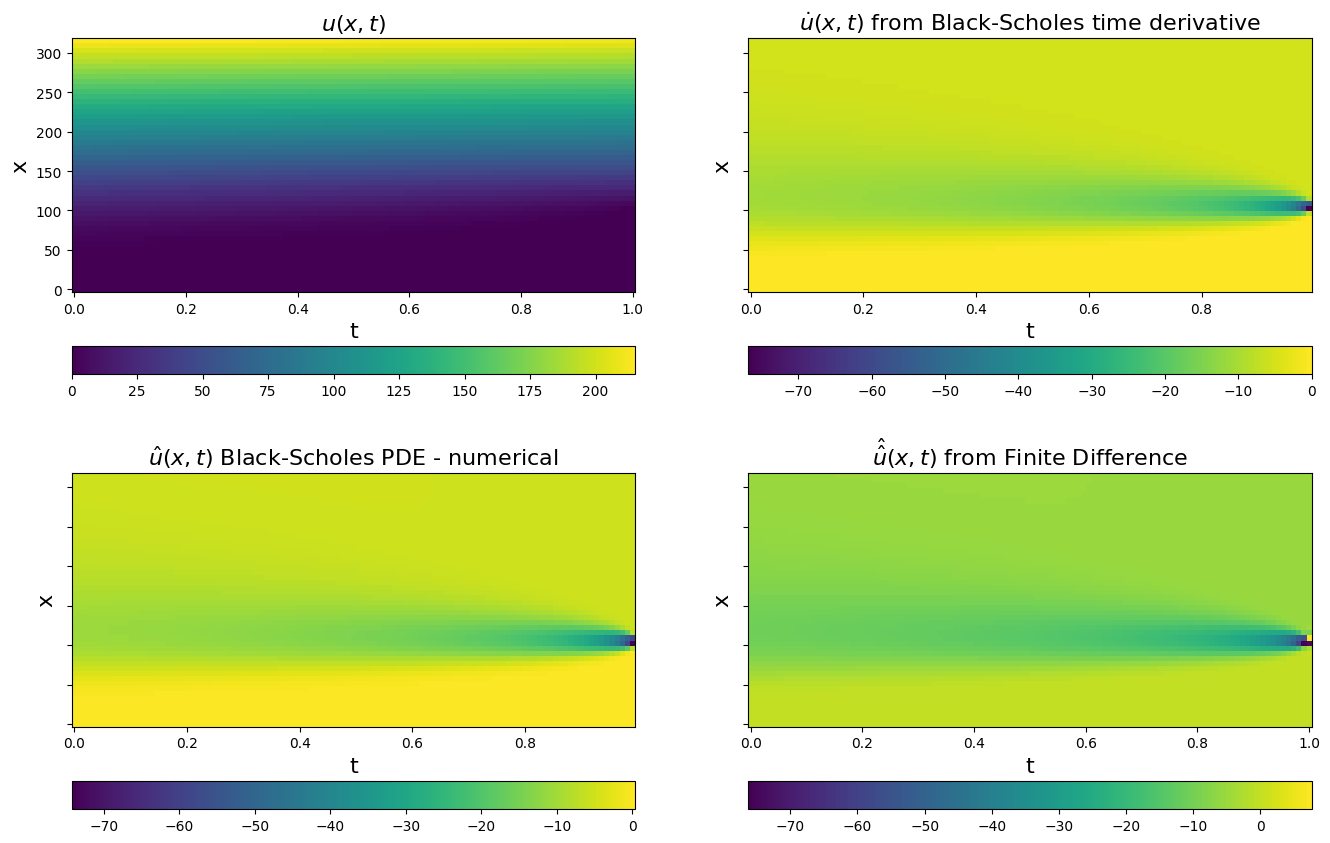

In [194]:
# n_arr = np.asarray([np.arange(0,spacesteps,1)]*timesteps).T
u_x = ps.FiniteDifference(axis=0,order = 6)._differentiate(u,t = dx)
u_xx = ps.FiniteDifference(axis=0,d=2,order = 8)._differentiate(u,t = dx)
u_t_ = ps.FiniteDifference(axis=1,order = 25)._differentiate(u,t = dt)
# v_dot = numerical_partial_black_scholes(u.T,r,sigma).T


# Plot u and u_dot
plt.figure(figsize=(16, 16))
plt.subplot(3, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)
plt.colorbar(orientation="horizontal")

# plt.subplot(3, 2, 5)
# plt.pcolormesh(t, x, v_dot)
# plt.xlabel("t", fontsize=16)
# plt.ylabel("x", fontsize=16)
# ax = plt.gca()
# ax.set_yticklabels([])
# plt.title(r"$\hat{\hat{\hat{u}}}(x, t)$ from DURA-MOS¸NEAGU", fontsize=16)
# plt.colorbar(orientation="horizontal")

u_dot = -(1/2)*((sigma**2)*(X.T[:,:-1]**2)*u_xx[:,:-1]) - (r*(X.T[:,:-1])*u_x[:,:-1]) + r*u[:,:-1]
plt.subplot(3, 2, 3)
plt.pcolormesh(t[:-1], x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\hat{u}(x, t)$ Black-Scholes PDE - numerical", fontsize=16)
plt.colorbar(orientation="horizontal")


plt.subplot(3, 2, 4)
plt.pcolormesh(t, x, u_t_)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\hat{\hat{u}}(x, t)$ from Finite Difference", fontsize=16)
plt.colorbar(orientation="horizontal")

plt.subplot(3, 2, 2)
plt.pcolormesh(t[:-1], x, u_t)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from Black-Scholes time derivative", fontsize=16)
plt.colorbar(orientation="horizontal")


# print('Error for DURA-MOS¸NEAGU Computation')
# print('RSE',np.sum((u_t - v_dot)**2)/np.sum((u_t - u_t.mean())**2))
# print('RMSE',(np.sqrt(np.sum((u_t - v_dot)**2).mean())))
print('Error for Finite Difference ')
print('RSE',np.sum((u_t_[:,:-1] - u_t)**2)/np.sum((u_t - u_t.mean())**2))
print('RMSE',(np.sqrt(np.sum((u_t - u_t_[:,:-1])**2).mean())))
print('Error for Numerical Black-Scholes')
print('RSE',np.sum((u_dot - u_t)**2)/np.sum((u_t - u_t.mean())**2))
print('RMSE',(np.sqrt(np.sum((u_dot - u_t)**2).mean())))

plt.show()

##### PySINDy

In [195]:
u = np.reshape(u, (len(x), len(t), 1))
u_dot  = np.reshape(u_dot, (*u_dot.shape, 1))
u_t  = np.reshape(u_t, (*u_t.shape, 1))
u_t_  = np.reshape(u_t_, (*u_t_.shape, 1))

# v_dot  = np.reshape(v_dot, (len(x), len(t), 1))
spatial_grid = np.reshape(X.T, (*X.T.shape, 1))

library_functions = [lambda x: x]
library_function_names = [lambda x: x]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_interaction = False,
    derivative_order=2,
    spatial_grid=x,
    include_bias=False,
    is_uniform=True,
    periodic=True # uniformly sampled in time
)

#Create Library with partial derivatives and spatial variable plus cross-terms
u_final = pde_lib.fit_transform(u)
u_final = np.concatenate((u_final,spatial_grid,spatial_grid**2),axis=2)
dic_var = {'x0':'u','x1':'u_x', 'x2':'u_xx','x3':'x','x4':'x^2'}
library_functions = [lambda x: x,lambda x,y: x*y]
library_function_names = [lambda x: dic_var[x],lambda x,y: dic_var[x] + '*' + dic_var[y]]
lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=False
)
lib_tr = lib.fit_transform(u_final)

In [196]:
# Add boundary conditional on T time of the derivative
# Create a new shape by adding 1 to the second dimension
original_shape = u_t.shape
new_shape = list(original_shape)
new_shape[1] += 1

_u_t = np.zeros(new_shape)
# Copy the original data into the new array up to the last layer

_u_t[:, :original_shape[1], :] = u_t



print('----------------------------Finite Difference--------------------------------')
#Fit the data using the finite difference approximation

print('STLSQ Regression')
optimizer = ps.STLSQ(threshold=5e-3, alpha=2e3)
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final,x_dot = u_t_)
# print(model.score(u_test))
model.print()
print('Error Model prediction against analytical solution:')
pred = model.predict(u_final)
print('R2',model.score(x = u_final,x_dot = _u_t))
print('RSE',np.sum((pred.flatten() - _u_t.flatten())**2)/np.sum((_u_t.flatten() - _u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - _u_t.flatten())**2).mean())))

print('\nMean threshold remove \n')
#Remove less participative terms
new_coef = threshold_remove(lib_tr,model.coefficients()[0],threshold = 0.1,axis=2,target = _u_t)
pred = lib_tr @ new_coef
print_model(new_coef,lib.get_feature_names())
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - _u_t.flatten())**2)/np.sum((_u_t.flatten() - _u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - _u_t.flatten())**2).mean())))

print('*'*50)


----------------------------Finite Difference--------------------------------
STLSQ Regression
(x0)' = -0.025 u + 0.074 u*u_x + -0.049 u_x*x + -0.077 u_xx*x^2
Error Model prediction against analytical solution:
R2 0.9158205004833595
RSE 0.0841794995166405
RMSE 106.97875566167785

Mean threshold remove 

(50, 110, 15)
u_t = + -0.17 u + 0.22 u*u_x + -0.05 u_x*x + -0.07 u_xx*x^2
Error Model prediction against analytical solution:
RSE 0.0804440794502991
RMSE 104.5782609239395
**************************************************


In [197]:

print('----------------------------Weak Formulation--------------------------------')

library_functions = [lambda x: x, lambda x: x * x,lambda x: X.T,lambda x: X.T**2]
library_function_names = [lambda x: x,lambda x: x + '*' + x,lambda x: 'x',lambda x: 'x**2']

pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=500,
)

optimizer = ps.STLSQ(threshold=1e-2, alpha=1e2)

model = ps.SINDy(feature_names = ['u'],feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
model.print()
lib_weak = np.concatenate((lib_tr[:,:,:7],lib_tr[:,:,8:]),axis=2)
pred = lib_weak @ model.coefficients()[0]
# print('Error Model prediction against analytical solution:')
# print('RSE',np.sum((pred.flatten() - _u_t.flatten())**2)/np.sum((_u_t.flatten() - _u_t.flatten().mean())**2))
# print('RMSE',(np.sqrt(np.sum((pred.flatten() - _u_t.flatten())**2).mean())))


----------------------------Weak Formulation--------------------------------
(u)' = 0.046 u + -0.048 xu_1 + -0.081 x**2u_11


In [198]:

print('----------------------------Ensemble method----------------------------')
optimizer = ps.STLSQ(threshold=1e-2, alpha=1e0)
# optimizer = ps.SR3(threshold=0.01,nu = .1 , max_iter=1000, tol=1e-10,thresholder='l0')
# optimizer = ps.SSR(alpha=.1,kappa = .001,)

model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final, x_dot = u_t_,
        library_ensemble =False,
        ensemble = True,
        n_candidates_to_drop=5,
        n_models = 300,
        n_subset = len(t) // 2,
        quiet=True)
library_ensemble_coefs = model.coef_list

mean_ensemble = np.mean(library_ensemble_coefs,axis=0)[0]
median_ensemble = np.median(library_ensemble_coefs,axis=0)[0]

print('Mean:')
print_model(mean_ensemble,lib.get_feature_names(),precision=3)
print('Median:')
print_model(median_ensemble,lib.get_feature_names(),precision=3)
#Fit the data using ensemble methos on the finite difference values

print('Error Model prediction against analytical solution:')
optimizer.coef_ = median_ensemble
pred = model.predict(u_final[:,:-1,:])
print('R2',model.score(x = u_final[:,:-1,:],x_dot = u_t))
print('RSE',np.sum((pred.flatten() - u_t.flatten())**2)/np.sum((u_t.flatten() - u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_t.flatten())**2).mean())))

print('\nMean threshold remove \n')
#Remove less participative terms
new_coef = threshold_remove(lib_tr[:,:-1,:],median_ensemble,target = u_t,threshold = 0.1,axis=2)
pred = lib_tr[:,:-1,:] @ new_coef
print_model(new_coef,lib.get_feature_names())
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - u_t.flatten())**2)/np.sum((u_t.flatten() - u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_t.flatten())**2).mean())))


----------------------------Ensemble method----------------------------
Mean:
u_t = + -0.005 u + -0.063 u_x + -0.0 u_xx + -0.001 x + 0.048 u*u_x + -0.018 u*u_xx + -0.0 u_x*u_xx + -0.045 u_x*x + 0.061 u_xx*x + -0.08 u_xx*x^2
Median:
u_t = + 0.049 u + -0.049 u_x*x + -0.013 u_xx*x + -0.08 u_xx*x^2
Error Model prediction against analytical solution:
R2 0.9971743098234398
RSE 0.0028256901765601745
RMSE 19.465610442059802

Mean threshold remove 

(50, 109, 15)
u_t = + 0.05 u + -0.05 u_x*x + -0.08 u_xx*x^2
Error Model prediction against analytical solution:
RSE 0.0016241693443612701
RMSE 14.75779289675999


##### Subsampling

In [199]:
num_points_to_sample = timesteps

# Generate random indices
random_rows = np.random.choice(u.shape[0], num_points_to_sample, replace=True)
# random_columns = np.concatenate(([0,-1],np.random.choice(u.shape[1], num_points_to_sample-2, replace=False)))

# Subsample the matrix
subsampled_u = np.ravel(u)[random_rows*timesteps + np.linspace(0,timesteps-1,timesteps,dtype=int)]
subsampled_x = x[random_rows]
subsampled_t = t

##### Interpolating for more points

In [200]:
interpol_dict = {

    'Cubic Spline': cubic_spline_interpolation, #Assumes regular grid
    'Smoothed Spline': smooth_spline_interpolation, # Good for noisy data
    'Linear': linear_interpolation,#Assumes regular grid
    'Bilinear':bilinear_interpolation, #Best for unstructured grid
    'Thin plate': thin_plate_splines_interpolation, #Best for case
    'Bicubic': bicubic_interpolation,#Best for unstructured grid
    'Rbf': rbf_interpolation,
    'Kriging': kriging_interpolation #Good with very few points
}


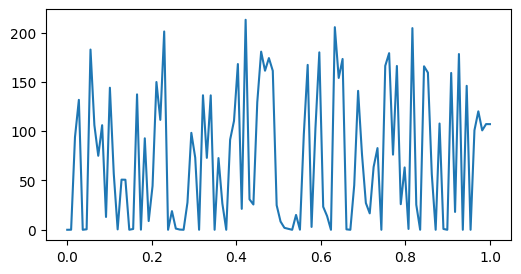

In [201]:
plt.figure(figsize=(6, 3))
plt.plot(t, subsampled_u)

Interpolation error for Original u
RSE: 0.0001607415704545455
RMSE: 9.442404766335972


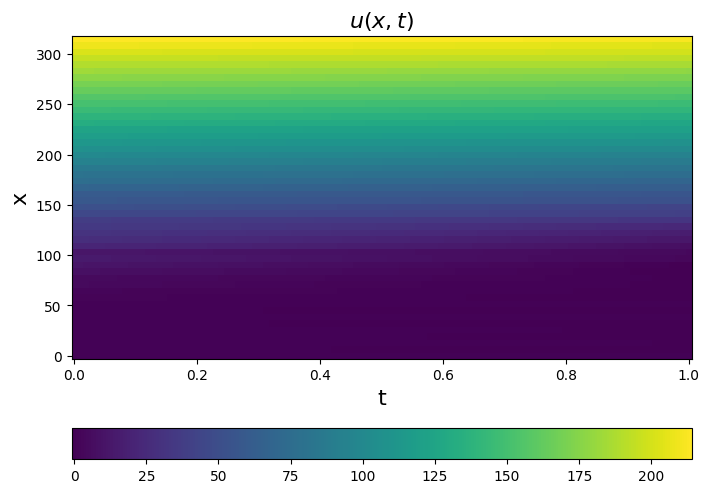

In [224]:
#Looking for the quality of interpolation
interpolation_method = 'Rbf'


n_time_points = 110
n_space_points =  50

interpol_u = interpol_dict[interpolation_method](subsampled_u,subsampled_t,subsampled_x,n_time_points,n_space_points)


x = np.linspace(0., K_*3, n_space_points)
t = np.linspace(0, T_, n_time_points)

# Plot u and u_dot
plt.figure(figsize=(8, 6))
plt.pcolormesh(t, x, interpol_u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)
plt.colorbar(orientation="horizontal")

#Error rate, interpoalte only in known points
interpol_u_test = interpol_dict[interpolation_method](subsampled_u,subsampled_t,subsampled_x,timesteps,spacesteps)
rse, rmse = calc_error(interpol_u_test,u)

In [241]:
interpol_u_x = ps.FiniteDifference(axis=0,order = 2)._differentiate(interpol_u,t = x)
interpol_u_xx = ps.FiniteDifference(axis=0,d=2,order = 2)._differentiate(interpol_u,t = x)
interpol_u_t = ps.FiniteDifference(axis=1,order = 1)._differentiate(interpol_u,t = dt)

interpol_u_ = np.ravel(interpol_u)[random_rows*timesteps + np.linspace(0,timesteps-1,timesteps,dtype=int)]
interpol_u_x_ = np.ravel(interpol_u_x)[random_rows*timesteps + np.linspace(0,timesteps-1,timesteps,dtype=int)]
interpol_u_xx_ =  np.ravel(interpol_u_xx)[random_rows*timesteps + np.linspace(0,timesteps-1,timesteps,dtype=int)]
interpol_u_t_ =  np.ravel(interpol_u_t)[random_rows*timesteps + np.linspace(0,timesteps-1,timesteps,dtype=int)]


interpol_lib = np.vstack((interpol_u_,interpol_u_x_,interpol_u_xx_,x[random_rows],x[random_rows]**2)).T

dic_var = {'x0':'u','x1':'u_x', 'x2':'u_xx','x3':'x','x4':'x^2'}
library_functions = [lambda x: x,lambda x,y: x*y]
library_function_names = [lambda x: dic_var[x],lambda x,y: dic_var[x] + '*' + dic_var[y]]

lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=False
)
fit_lib = lib.fit_transform(interpol_lib)


In [251]:
flatten_u_t = np.ravel(_u_t)[random_rows*timesteps + np.linspace(0,n_time_points-1,n_time_points,dtype=int)]

print('------------Finite Difference------------')
optimizer = ps.STLSQ(threshold=1e-2, alpha=1e3)

model = ps.SINDy(feature_library=lib, optimizer=optimizer)


model.fit(interpol_lib,x_dot = interpol_u_t_)
model.print()

print('Error Model prediction against analytical solution:')
pred = model.predict(interpol_lib)
print('R2',model.score(x = interpol_lib,x_dot = flatten_u_t))
print('RSE',np.sum((pred.flatten() - flatten_u_t)**2)/np.sum((flatten_u_t - flatten_u_t.mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - flatten_u_t)**2))).mean())

print('\nMean threshold remove \n')
#Remove less participative terms
new_coef = threshold_remove(fit_lib,model.coefficients()[0],threshold = 0.05,axis=1,target = flatten_u_t)
pred = fit_lib @ new_coef
print_model(new_coef,lib.get_feature_names())
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - flatten_u_t)**2)/np.sum((flatten_u_t - flatten_u_t.mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - flatten_u_t)**2))).mean())



------------Finite Difference------------
(x0)' = -0.028 u + -0.061 x + 0.214 u*u_x + -0.070 u_x*x
Error Model prediction against analytical solution:
R2 0.6811281982863626
RSE 0.3188718017136374
RMSE 26.130476119621836

Mean threshold remove 

(110, 15)
u_t = + -0.25 u + 0.44 u*u_x + -0.14 u_x*x
Error Model prediction against analytical solution:
RSE 0.42762692178158507
RMSE 30.260199342200696


In [254]:

print('----------------------------Ensemble method----------------------------')
optimizer = ps.STLSQ(threshold=1e-2, alpha=1e3)
# optimizer = ps.SR3(threshold=0.01,nu = .1 , max_iter=1000, tol=1e-10,thresholder='l0')
# optimizer = ps.SSR(alpha=.1,kappa = .001,)

model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(interpol_lib, x_dot = interpol_u_t_,
        library_ensemble =True,
        ensemble = True,
        n_candidates_to_drop=5,
        n_models = 300,
        n_subset = len(t) // 2,
        quiet=True)
library_ensemble_coefs = model.coef_list

mean_ensemble = np.mean(library_ensemble_coefs,axis=0)[0]
median_ensemble = np.median(library_ensemble_coefs,axis=0)[0]

print('Mean:')
print_model(mean_ensemble,lib.get_feature_names(),precision=3)
print('Median:')
print_model(median_ensemble,lib.get_feature_names(),precision=3)
#Fit the data using ensemble methos on the finite difference values

print('Error Model prediction against analytical solution:')
pred = model.predict(interpol_lib)
print('R2',model.score(x = interpol_lib,x_dot = flatten_u_t))
print('RSE',np.sum((pred.flatten() - flatten_u_t)**2)/np.sum((flatten_u_t - flatten_u_t.mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - flatten_u_t)**2))).mean())

print('\nMean threshold remove \n')
#Remove less participative terms
new_coef = threshold_remove(fit_lib,median_ensemble,threshold = 0.05,axis=1,target = flatten_u_t)
pred = fit_lib @ new_coef
print_model(new_coef,lib.get_feature_names())
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - flatten_u_t)**2)/np.sum((flatten_u_t - flatten_u_t.mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - flatten_u_t)**2))).mean())



----------------------------Ensemble method----------------------------
Mean:
u_t = + 0.047 u + -0.062 x + 0.131 u*u_x + -0.001 u*u_xx + -0.064 u_x*x + -0.016 u_xx*x
Median:
u_t = + 0.042 u + -0.068 x + 0.135 u*u_x + -0.062 u_x*x
Error Model prediction against analytical solution:
R2 0.6811281982863626
RSE 0.3188718017136374
RMSE 26.130476119621836

Mean threshold remove 

(110, 15)
u_t = + -0.25 u + 0.44 u*u_x + -0.14 u_x*x
Error Model prediction against analytical solution:
RSE 0.42762692178158507
RMSE 30.260199342200696


In [258]:
print('-'*100)
# Create a boolean mask to identify non-NaN values
non_nan_mask = ~np.isnan(interpol_u)

# Use the mask to extract only the non-NaN values
non_nan_values = interpol_u[non_nan_mask]

# If you want to create a new matrix without NaN values
interpol_u_ = np.where(non_nan_mask, interpol_u, 0)

interpol_u_ = interpol_u_.reshape(interpol_u_.shape[0],interpol_u_.shape[1],1)

optimizer = ps.STLSQ(threshold=1e-3, alpha=1e2)

calc_error(interpol_u,u)
print('------------Finite Difference------------')
#Fit the data using the finite difference approximation
library_functions = [lambda x: x, lambda x: x * x,lambda x: X.T,lambda x: X.T**2]
library_function_names = [lambda x: x,lambda x: x + '*' + x,lambda x: 'x',lambda x: 'x**2']

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_interaction = True,
    derivative_order=2,
    spatial_grid=x,
    include_bias=False,
    is_uniform=False,
    periodic=False # uniformly sampled in time
)
model = ps.SINDy(feature_names = ['u'],feature_library=pde_lib, optimizer=optimizer)


model.fit(interpol_u_)
model.print()
print('Approximation error for real u:',model.score(u))
print('------------Weak Formulation------------')

optimizer = ps.STLSQ(threshold=0, alpha=0)

library_functions = [lambda x: x, lambda x: x * x,lambda x: X.T,lambda x: X.T**2]
library_function_names = [lambda x: x,lambda x: x + '*' + x,lambda x: 'x',lambda x: 'x**2']

weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=False,
    K=500,
)
model = ps.SINDy(feature_names = ['u'],feature_library=weak_lib, optimizer=optimizer)
model.fit(interpol_u_)
model.print()
print('Approximation error for real u:',model.score(u))
print()

print('------------Ensemble------------')
optimizer = ps.STLSQ(threshold=1e-2, alpha=1e3)
# optimizer = ps.SR3(threshold=0.01,nu = .1 , max_iter=1000, tol=1e-10,thresholder='l0')
# optimizer = ps.SSR(alpha=.1,kappa = .001,)

model = ps.SINDy(feature_names = ['u'],feature_library=pde_lib, optimizer=optimizer)
model.fit(interpol_u_,
        library_ensemble =True, 
        n_candidates_to_drop=3,
        n_models = 300,
        n_subset = len(t) // 2,
        quiet=True)
library_ensemble_coefs = model.coef_list

mean_ensemble = np.mean(library_ensemble_coefs,axis=0)[0]
median_ensemble = np.median(library_ensemble_coefs,axis=0)[0]

print_model(mean_ensemble,lib.get_feature_names(),precision=3)
print_model(median_ensemble,lib.get_feature_names(),precision=3)
print()
print('Approximation error for real u:',model.score(u))


print('-'*100)


----------------------------------------------------------------------------------------------------
Interpolation error for Original u
RSE: 0.0001607415704545455
RMSE: 9.442404766335972
------------Finite Difference------------
(u)' = -0.059 u_1
Approximation error for real u: 0.0034070096110820902
------------Weak Formulation------------
(u)' = 0.372 u + 0.002 u*u + 0.064 x + -0.002 x**2 + -10.603 u_1 + -7.134 u_11 + -0.300 uu_1 + -0.003 u*uu_1 + -0.132 xu_1 + 0.002 x**2u_1 + 16.183 uu_11 + 0.069 u*uu_11 + 7.604 xu_11 + -0.092 x**2u_11
Approximation error for real u: 0.7961593972330592

------------Ensemble------------
u_t =
u_t =

Approximation error for real u: -1.4547696471029483
----------------------------------------------------------------------------------------------------
